In [1]:
%matplotlib inline

In [4]:
!pip install arviz==0.9.0
!pip install --upgrade pymc3==3.9

Requirement already up-to-date: pymc3==3.9 in /usr/local/lib/python3.7/dist-packages (3.9.0)


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import warnings
import json
import nltk
from datetime import datetime
import pymc3 as pm, theano.tensor as tt

In [6]:
data = pd.read_csv('pnd_features_new.csv', index_col=0)
data

,Channel,Currency,Exchange,Duration,Volume,Price before pump,Max price,Our buy price,Our profit,Theoretical buy price,Theoretical profit,theoretical_profit,success,theoretical_return,relative_volume,yobit,bittrex,cryptopia,volume_yobit,volume_cryptopia,volume_bittrex,duration,month,year,ranked,coin_cap,coin_volume,coin_ranking,weekday,hour,2018year,2019year,2020year,2021year,AM,month_cos,month_sin,hour_cos,hour_sin,channel
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-06-17 19:45:02+00:00,Tornado Signals,BNBX,Yobit,1:31,0.12,1.027000e-05,2.300000e-05,1.900000e-05,21.05%,1.899000e-05,21.12%,0.2112,1,1.2112,1.168452e+04,1,0,0,1.168452e+04,0.000000,0.000000e+00,91,6,2018,0,0.000000e+00,0.0,1001,6,19,1,0,0,0,0,-1.000000e+00,1.224647e-16,0.460065,-0.887885,0
2018-06-18 19:45:03+00:00,Tornado Signals,RR,Yobit,0:09,0.16,4.600000e-07,1.800000e-06,1.390000e-06,29.50%,1.390000e-06,29.50%,0.2950,1,1.2950,3.478261e+05,1,0,0,3.478261e+05,0.000000,0.000000e+00,9,6,2018,0,0.000000e+00,0.0,1001,0,19,1,0,0,0,0,-1.000000e+00,1.224647e-16,0.460065,-0.887885,0
2018-06-19 15:53:52+00:00,Crypto Signal Crazy Community?,XVG,Bittrex,9:46,6.70,4.490000e-06,4.490000e-06,4.480000e-06,0.22%,4.490000e-06,0.00%,0.0000,0,1.0000,1.492205e+06,0,1,0,0.000000e+00,0.000000,1.492205e+06,586,6,2018,1,6.000251e+08,7324239.0,33,1,15,1,0,0,0,0,-1.000000e+00,1.224647e-16,-0.576680,-0.816970,1
2018-06-19 19:45:02+00:00,Tornado Signals,WIT,Yobit,0:05,0.16,1.000000e-07,4.500000e-07,3.100000e-07,45.16%,2.200000e-07,104.55%,1.0455,1,2.0455,1.600000e+06,1,0,0,1.600000e+06,0.000000,0.000000e+00,5,6,2018,0,0.000000e+00,0.0,1001,1,19,1,0,0,0,0,-1.000000e+00,1.224647e-16,0.460065,-0.887885,0
2018-06-20 15:00:17+00:00,Crypto Pump Island,TRK,Cryptopia,1:02,0.25,4.300000e-07,7.700000e-07,6.600000e-07,16.67%,4.900000e-07,57.14%,0.5714,1,1.5714,5.813953e+05,0,0,1,0.000000e+00,581395.348837,0.000000e+00,62,6,2018,0,0.000000e+00,0.0,1001,2,15,1,0,0,0,0,-1.000000e+00,1.224647e-16,-0.576680,-0.816970,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-30 14:56:39+00:00,Cryptonians (Free Signals and News Update),NEAR,Binance,5:48,56.61,1.034000e-04,1.125000e-04,1.085000e-04,3.69%,1.084000e-04,3.78%,0.0378,0,1.0378,5.474855e+05,0,0,0,0.000000e+00,0.000000,0.000000e+00,348,3,2021,1,1.148612e+09,91631823.0,53,1,14,0,0,0,1,0,6.123234e-17,1.000000e+00,-0.775711,-0.631088,54
2021-03-30 16:48:20+00:00,Pro Analysis,STORJ,Binance,0:00,165.12,4.664000e-05,5.597000e-05,5.329000e-05,5.03%,5.356000e-05,4.50%,0.0450,0,1.0450,3.540309e+06,0,0,0,0.000000e+00,0.000000,0.000000e+00,0,3,2021,1,1.608355e+08,63955197.0,147,1,16,0,0,0,1,0,6.123234e-17,1.000000e+00,-0.334880,-0.942261,68
2021-03-31 14:11:50+00:00,Binance Moon Pump?,BTG,Binance,3:32,4.82,6.440000e-04,6.580000e-04,6.460000e-04,1.86%,6.460000e-04,1.86%,0.0186,0,1.0186,7.484472e+03,0,0,0,0.000000e+00,0.000000,0.000000e+00,212,3,2021,1,4.231507e+08,58979211.0,95,2,14,0,0,0,1,0,6.123234e-17,1.000000e+00,-0.775711,-0.631088,43


In [7]:
#　dependent and indepenedet variables
var_list = ['relative_volume', 'duration', 'ranked', 'yobit', 'bittrex', 'cryptopia', 'AM', 
            '2019year', '2020year', '2021year', 'volume_yobit', 'volume_bittrex', 'volume_cryptopia']
y = data['theoretical_return']
x = data[var_list]

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (3 chains in 1 job)
NUTS: [sigma, eta, tau, beta]


Sampling 3 chains for 3_000 tune and 7_000 draw iterations (9_000 + 21_000 draws total) took 303 seconds.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta[0],0.000,0.000,-0.000,0.000,0.000,0.000,36128.0,21000.0,36188.0,14724.0,1.0
beta[1],-0.000,0.000,-0.000,0.000,0.000,0.000,32657.0,15042.0,32645.0,16161.0,1.0
beta[2],0.053,0.022,0.012,0.093,0.000,0.000,24973.0,22552.0,24987.0,16577.0,1.0
beta[3],0.372,0.030,0.316,0.429,0.000,0.000,23276.0,23276.0,23267.0,17631.0,1.0
beta[4],-0.005,0.047,-0.093,0.084,0.000,0.000,27996.0,12424.0,27982.0,18045.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
eta[111],-0.009,0.116,-0.224,0.214,0.001,0.001,40739.0,7861.0,40704.0,15450.0,1.0
eta[112],0.009,0.118,-0.213,0.228,0.001,0.001,44557.0,7853.0,44561.0,14593.0,1.0
eta[113],-0.027,0.106,-0.233,0.166,0.001,0.001,39795.0,8564.0,39580.0,15337.0,1.0
tau,0.135,0.014,0.109,0.162,0.000,0.000,10399.0,10399.0,10227.0,12864.0,1.0


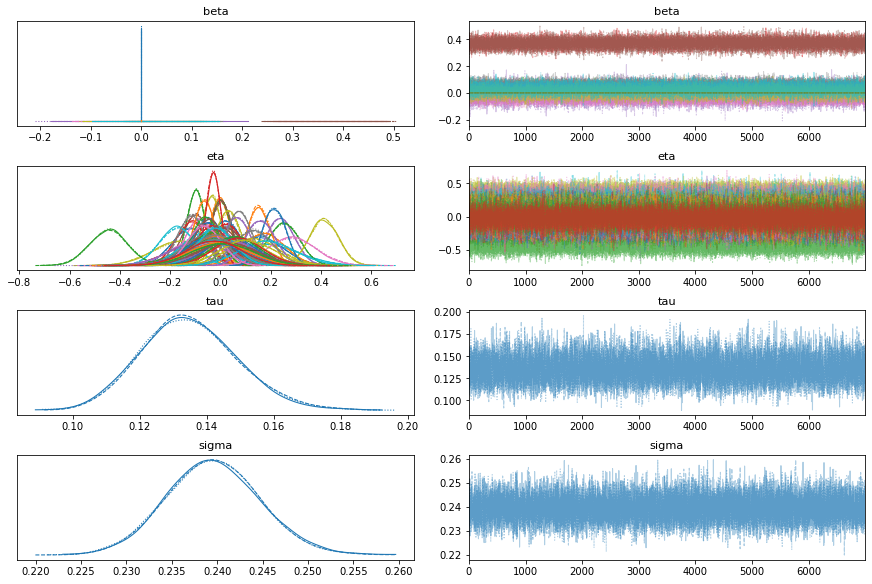

In [8]:
# Normal distribution MLE
n, k  = x.shape
b0 = np.zeros(k)
tau0 = 0.01 * np.eye(k)


with pm.Model() as model:
    coef = pm.MvNormal('beta', mu=b0, tau=tau0, shape=k)
    tau = pm.HalfCauchy('tau', 5)
    eta = pm.Normal('eta', mu=0, sigma=tau, shape=len(data['channel'].unique()))
    eq = eta[data['channel'].values] + pm.math.dot(x, coef)

    # regression
    sigma = pm.HalfCauchy('sigma', 5)
    est = pm.Normal('y', mu=eq, sigma= sigma, observed=pm.math.log(y))
    
# sampling
with model:
    # get sample from 3001th, three chains
    trace = pm.sample(7000, tune=3000, chains = 3, random_seed=0, start = pm.find_MAP())

_ = pm.traceplot(trace)
pm.summary(trace)

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


1.0
1.0


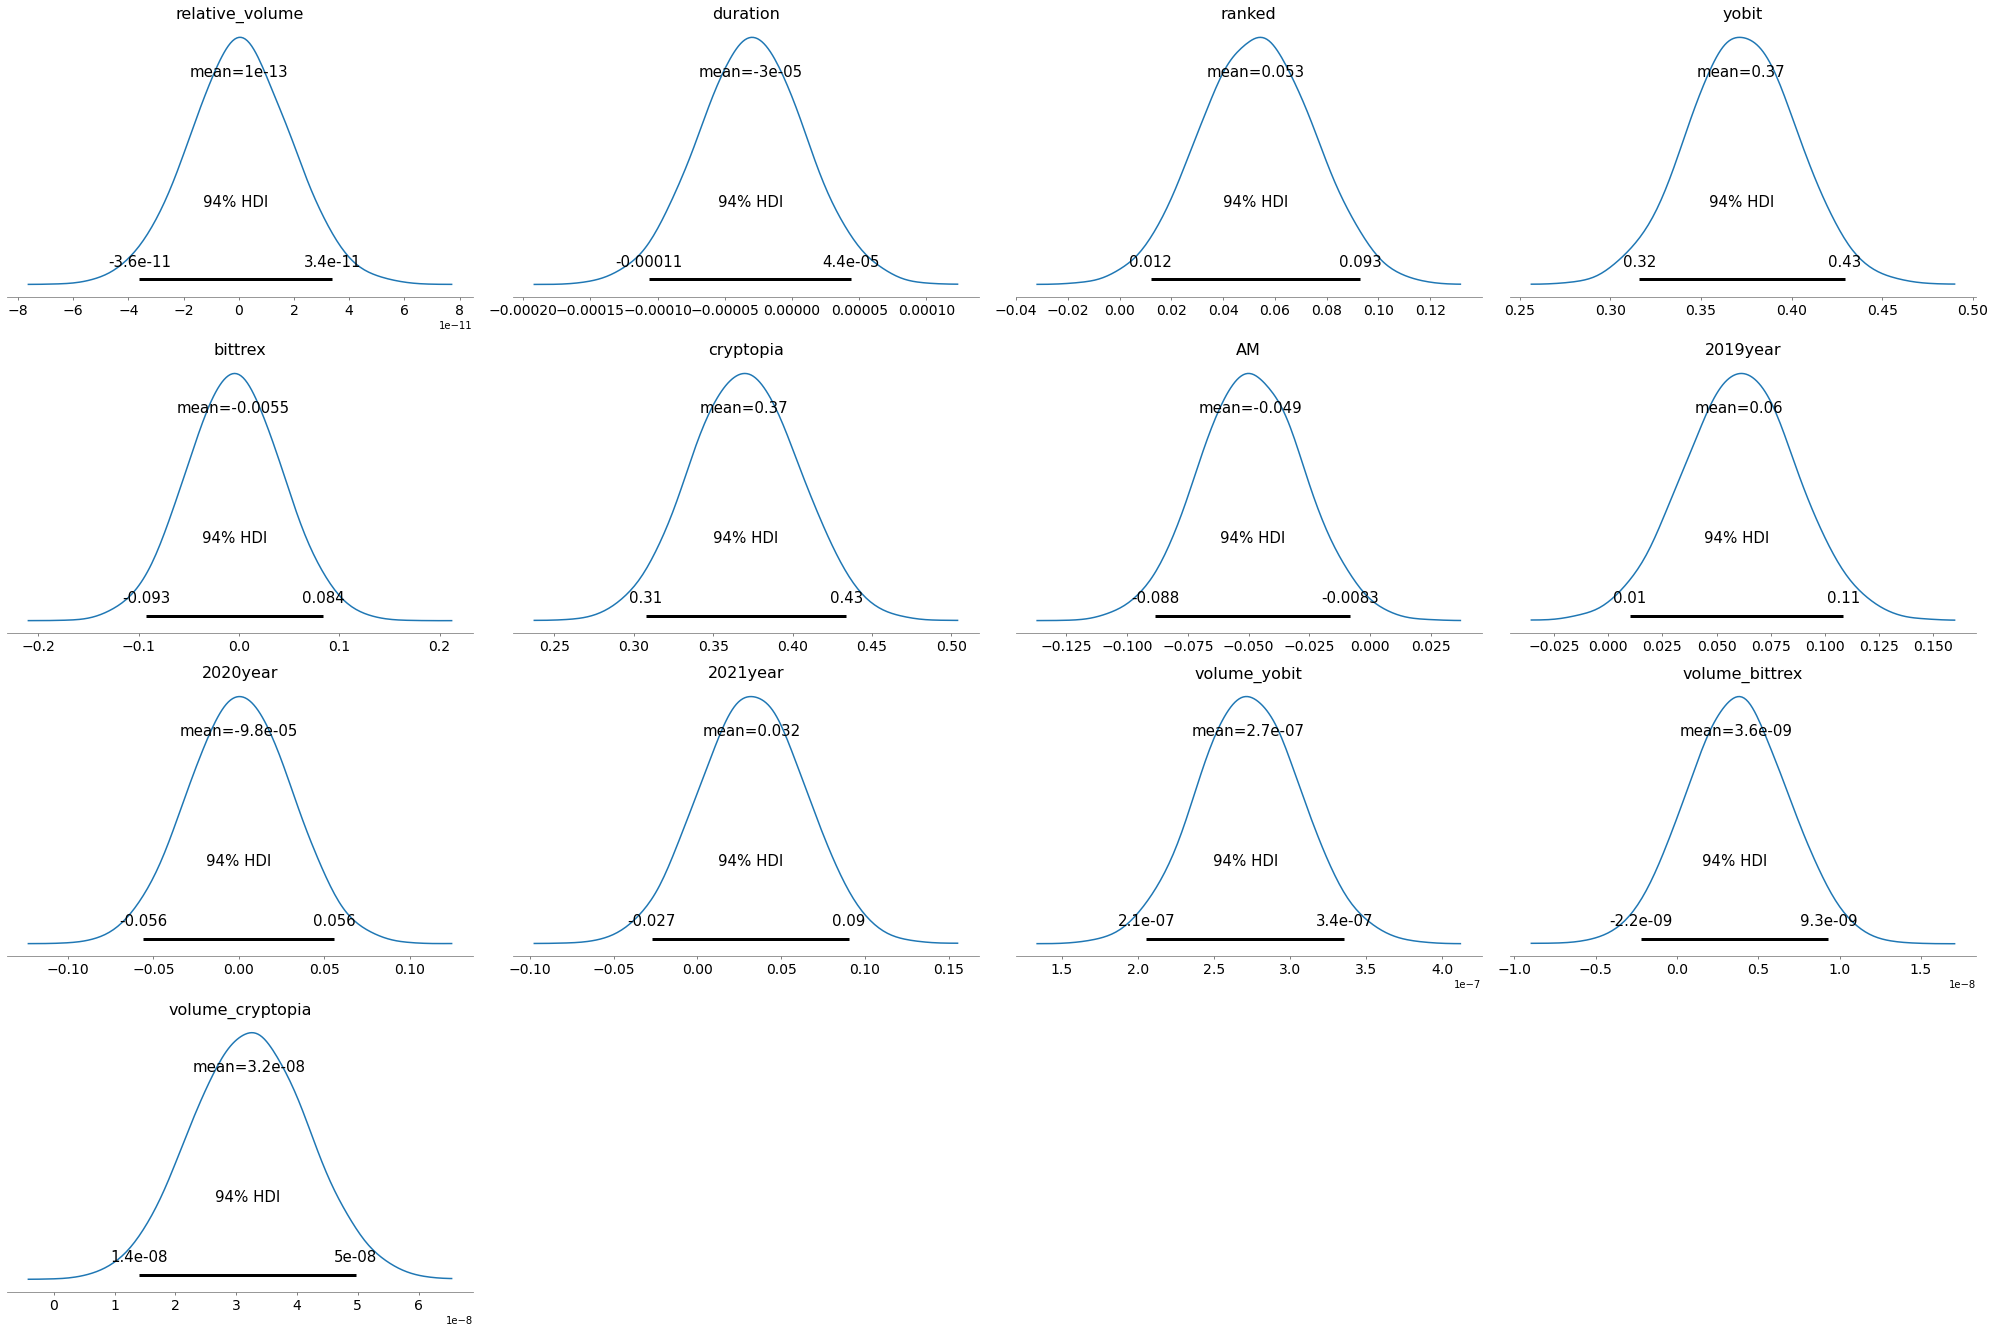

In [9]:
rhat = pm.summary(trace)['r_hat']
print(min(rhat))
print(max(rhat))
sim_param = dict([('{}'.format(var_list[i]), trace['beta'][:,i]) for i in range(k)])
pm.plot_posterior(sim_param, kind='kde', point_estimate='mean')
plt.show()

/usr/local/lib/python3.7/dist-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)
/usr/local/lib/python3.7/dist-packages/arviz/stats/stats.py:486: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


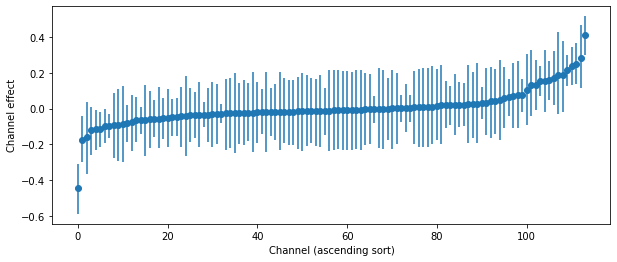

In [10]:
# telegram channel effect ascending order
df_hpd = pd.DataFrame(pm.stats.hpd(trace['eta']),
                      columns=['hpd_low', 'hpd_high'])
df_median = pd.DataFrame(np.quantile(trace['eta'], 0.5, axis=0),
                         columns=['hpd_median'])
df_hpd = df_hpd.join(df_median)
df_hpd['relative_lower'] = df_hpd.hpd_median - df_hpd.hpd_low
df_hpd['relative_upper'] = df_hpd.hpd_high - df_hpd.hpd_median
df_hpd = df_hpd.sort_values(by='hpd_median')
df_hpd = df_hpd.reset_index()

fig, axs = plt.subplots(figsize=(10,4))
axs.errorbar(df_hpd.index, df_hpd.hpd_median,
             yerr=(df_hpd[['relative_lower', 'relative_upper']].values).T,
             fmt='o')

axs.set_xlabel('Channel (ascending sort)')
axs.set_ylabel('Channel effect')
plt.savefig('img/channel_effect.jpg')

In [11]:
betas = []
for i in range(k):
    betas.append('beta[{}]'.format(i))
table = pm.summary(trace, round_to=16).loc[betas]
var_names = ['volume', 'duration', 'ranked', 'yobit', 'bittrex', 'cryptopia', 'AM', '2019', '2020', '2021', 'volume*yobit', 'volume*bittrex', 'volume*cryptopia']
table.index = var_names
hpd = pm.stats.hpd(trace['beta'])
hpd = pd.DataFrame(hpd, index=var_names, columns=['hpd1', 'hpd2'])
table = table[['mean', 'sd', 'r_hat']].merge(hpd, right_index=True, left_index=True)
pd.options.display.precision = 3
display(table)

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)
/usr/local/lib/python3.7/dist-packages/arviz/stats/stats.py:486: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


,mean,sd,r_hat,hpd1,hpd2
volume,1.034e-13,1.851e-11,1.000,-3.603e-11,3.391e-11
duration,-3.049e-05,3.977e-05,1.000,-1.061e-04,4.394e-05
ranked,5.257e-02,2.170e-02,1.001,1.211e-02,9.286e-02
yobit,3.719e-01,3.006e-02,1.001,3.160e-01,4.292e-01
bittrex,-5.463e-03,4.678e-02,1.000,-9.263e-02,8.366e-02
cryptopia,3.692e-01,3.387e-02,1.000,3.075e-01,4.338e-01
AM,-4.936e-02,2.127e-02,1.000,-8.837e-02,-8.332e-03
2019,6.043e-02,2.606e-02,1.000,9.975e-03,1.085e-01
2020,-9.826e-05,2.989e-02,1.000,-5.597e-02,5.581e-02
2021,3.213e-02,3.149e-02,1.000,-2.736e-02,9.026e-02
